In [4]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd

In [6]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [13]:
# Find first date in database for API
first_date = session.query(Measurement.date).first()
first_date = list(first_date)[0]
print(first_date)

2010-01-01


In [15]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Extract the latest date in the measurement table.
latest_date = (session.query(Measurement.date)
                      .order_by(Measurement.date.desc())
                      .first())
latest_date
latest_date = list(latest_date)[0]
print(latest_date)
# Is there a way to do this with out hard coding the end date, 
#so that when the database end date changes that this query would still work.

# Calculate the date 1 year ago from the last data point in the database
end_date = dt.date(2017,8,23)
start_date = end_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
# Since some dates are enter more than once, you need the max enter precip for any given day
precipitation = (session
                        .query(Measurement.date, Measurement.prcp)
                        .filter(Measurement.date <= end_date, Measurement.date >= start_date)
                        .order_by(Measurement.date)
                        .all())

#func.max(Measurement.prcp)
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df = pd.DataFrame(precipitation, columns = ['Date', 'Precip']).dropna(how='any')
precipitation_df.set_index(precipitation_df.Date)
precipitation_df.head()

2017-08-23


,Date,Precip
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79


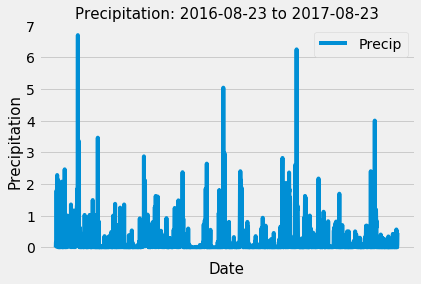

In [16]:
# Sort the dataframe by date.
precipitation_df.set_index(precipitation_df.Date)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Precipitation', fontsize = 15)
plt.title(f'Precipitation: {start_date} to {end_date}', fontsize = 15)
plt.xticks([])
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precip
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(Measurement.station).distinct(Measurement.station).count()

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_stats = (session
     .query(Measurement.station, func.count(Measurement.station))
     .group_by(Measurement.station)
     .order_by(func.count(Measurement.station).desc())
     .all())
station_stats

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
max_station = station_stats[0][0]
max_station

max_station_stats = (session
                            .query(func.min(Measurement.tobs), 
                                   func.max(Measurement.tobs), 
                                   func.avg(Measurement.tobs))
                            .filter(Measurement.station == max_station)
                            .all())
max_station_stats

[(54.0, 85.0, 71.66378066378067)]

In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_station_high = (session
    .query(Measurement.date, func.avg(Measurement.tobs))
    .filter(Measurement.date <= end_date, Measurement.date >= start_date, Measurement.station == max_station)
    .group_by(Measurement.date)
    .all())
tobs_df = pd.DataFrame(tobs_station_high, columns = ['Date', 'tobs'])
tobs_df.head()

,Date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


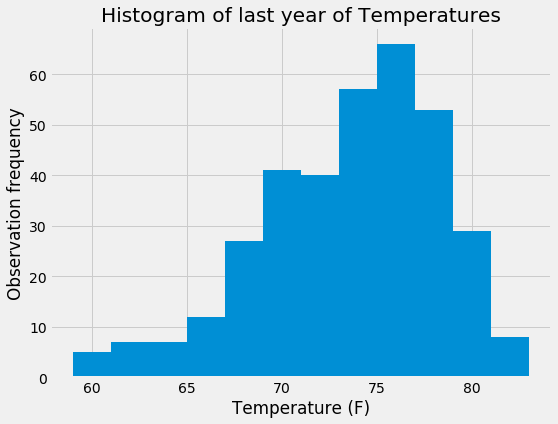

In [48]:
#counts = tobs_df.tobs.value_counts().to_dict()
#frequency = pd.DataFrame([counts]).T

#frequency.plot.bar()
plt.figure(figsize=(8,6))
plt.hist(tobs_df.tobs,bins = 12)
plt.title('Histogram of last year of Temperatures')
plt.xlabel('Temperature (F)')
plt.ylabel('Observation frequency')
plt.show()


In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    "TMIN, TAVG, and TMAX for a list of dates."
    
    """"Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
        
    return (session
                .query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))
                .filter(Measurement.date >= start_date)
                .filter(Measurement.date <= end_date)
                .all())

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
Trip_Temp = calc_temps('2017-04-24', '2017-05-07')
print(Trip_Temp)

[(58.0, 74.23255813953489, 81.0)]


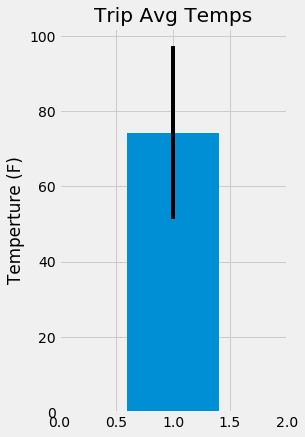

In [43]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x = 1
plt.figure(figsize=(4,6))
plt.bar(x,Trip_Temp[0][1], yerr = [Trip_Temp[0][2] - Trip_Temp[0][0]])
plt.tight_layout()
plt.xlim(0,2)
plt.title('Trip Avg Temps')
plt.ylabel('Temperture (F)')
plt.show()

In [98]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start_date = '2017-04-24'
trip_end_date = '2017-05-07'
Trip_Rainfall = (session
                     .query(Station.station, 
                            Station.name, 
                            Station.latitude, 
                            Station.longitude, 
                            Station.elevation, 
                            func.sum(Measurement.prcp))
                     .filter(Measurement.station == Station.station)
                     .filter(Measurement.date >= trip_start_date)
                     .filter(Measurement.date <= trip_end_date)
                     .group_by(Station.station)
                     .order_by(func.sum(Measurement.prcp).desc())
                .all())
                     
Trip_Rainfall

[('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  7.640000000000001),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 4.44),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  2.8399999999999994),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  2.5599999999999996),
 ('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  2.3499999999999996),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.27),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, None)]

In [51]:
# Converted the previous query into a dataframe for easy viewing.
Trip_Rainfall_df = pd.DataFrame(Trip_Rainfall, columns= ['station', 'name', 'latitude','longitude', 'elevation','total_rainfall'])
Trip_Rainfall_df

,station,name,latitude,longitude,elevation,total_rainfall
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,7.64
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,4.44
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.84
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.56
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,2.35
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.27
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,NaN


## Optional Challenge Assignment

In [52]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [53]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

# Set the start and end date of the trip
start_date = dt.date(2017,4,24)
end_date = dt.date(2017,5,7)

trip_days = end_date - start_date

trip_dates = []

# Use the start and end date to create a range of dates
for n in range(trip_days.days):
    trip_dates.append(start_date + dt.timedelta(n))


# Stip off the year and save a list of %m-%d strings
trip_dates_md = [trip_dates[i].strftime('%m-%d') for i, date in enumerate(trip_dates)]

# Loop through the list of %m-%d strings and calculate the normals for each date
for date in trip_dates_md:
    normals.append(daily_normals(date))
    
normals

[[(67.0, 73.3103448275862, 80.0)],
 [(66.0, 73.96551724137932, 83.0)],
 [(66.0, 74.01724137931035, 81.0)],
 [(65.0, 72.87272727272727, 81.0)],
 [(63.0, 73.46428571428571, 79.0)],
 [(66.0, 73.30357142857143, 81.0)],
 [(58.0, 71.5576923076923, 78.0)],
 [(65.0, 72.75925925925925, 79.0)],
 [(65.0, 73.05084745762711, 79.0)],
 [(67.0, 73.41071428571429, 84.0)],
 [(65.0, 73.59649122807018, 78.0)],
 [(67.0, 73.39655172413794, 79.0)],
 [(66.0, 73.14035087719299, 80.0)]]

In [54]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame.from_records([normals[i][0] for i,val in enumerate(normals)], columns = ['Tmin','Tavg','Tmax'])
normals_df['Date'] = trip_dates
normals_df = normals_df[['Date','Tmin','Tavg','Tmax']]
normals_df.set_index(['Date'],inplace = True)
normals_df

,Tmin,Tavg,Tmax
Date,,,
2017-04-24,67.0,73.310345,80.0
2017-04-25,66.0,73.965517,83.0
2017-04-26,66.0,74.017241,81.0
2017-04-27,65.0,72.872727,81.0
2017-04-28,63.0,73.464286,79.0
2017-04-29,66.0,73.303571,81.0
2017-04-30,58.0,71.557692,78.0
2017-05-01,65.0,72.759259,79.0
2017-05-02,65.0,73.050847,79.0


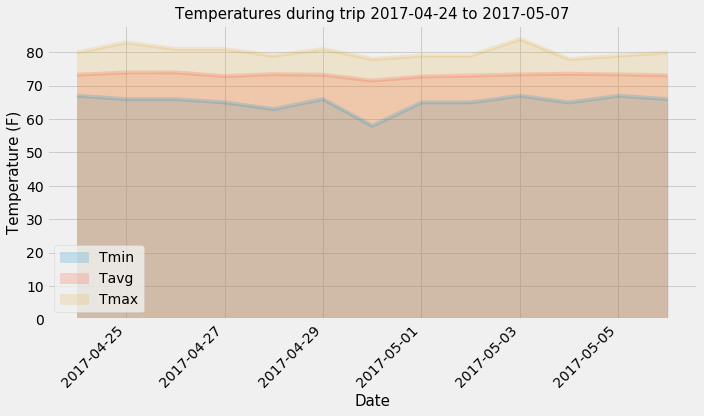

In [95]:
# Plot the daily normals as an area plot with `stacked=False`
fig, ax = plt.subplots()

normals_df.plot(kind = 'area',stacked = False,alpha =0.2, ax=ax, figsize=(10,6))
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Temperature (F)', fontsize = 15)
plt.minorticks_off()
plt.xticks(rotation = 45, ha='right')
plt.legend(loc= 'lower left')
plt.title(f'Temperatures during trip {start_date} to {end_date}', fontsize = 15)
plt.tight_layout()
plt.show()